In [16]:
import logging
import time
from pprint import pprint
from typing import List

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import pyro
import pyro.distributions as dist
import pyro.optim as optim
import seaborn as sns
import torch
from IPython.display import HTML
from pyro.infer import SVI, Predictive, Trace_ELBO
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean

from collab2.foraging.fish import StochasticFish_IndependentRates,animate_trajectories
from collab2.foraging.toolkit import (
    animate_predictors,
    dataObject,
    derive_predictors_and_scores,
    plot_coefs,
    rescale_to_grid,
    subsample_frames_constant_frame_rate
)

## Common parameters for simulations and predictor derivations

In [17]:
# Schooling simulations params
N = 6
arena_size = 100
Tmax = 10
L = 80
sigma_v = 5
sigma_t = 0.2
vscale = 10
rate = 10

# Predictor/score derivation params 
grid_size = 100
leeway = 10
window_size_multiplier = 0.2
grid_sampling_fraction = 1

score_kwargs = {
    "nextStep_sublinear" : {"nonlinearity_exponent" : 0.5},
    "nextStepExponential" : {"decay_length" : 5},
}

## Helper functions to generate derivedDF

In [18]:
def get_predictors_from_sim(
    sim,
    grid_size=100,
    frames_skipped=1,
    leeway=10,
    verbose=False,
    grid_sampling_fraction=1,
    normalize=True,
    window_size_multiplier = 0.5,
    score_kwargs = None
):

    # choose frames_skipped based on dt and vscale if not provided
    if frames_skipped is None:
        frames_skipped = max(1, int(0.01 * sim.arena_size / (sim.vscale * sim.dt)))

    print(f"Time points skipped for subsampling : {frames_skipped}")

    # get DataFrame
    x = sim.trajectories[:, :, 0].reshape(-1)
    y = sim.trajectories[:, :, 1].reshape(-1)
    num_frames = sim.trajectories.shape[1]
    num_foragers = sim.trajectories.shape[0]
    time = np.tile(np.arange(num_frames), num_foragers)
    foragers = np.concatenate([i * np.ones(num_frames) for i in range(num_foragers)])

    data = {
        "x": x,
        "y": y,
        "time": time,
        "forager": foragers,
    }

    foragersDF = pd.DataFrame(data)

    # discretize to grid
    gridMin = -sim.arena_size
    gridMax = sim.arena_size
    foragersDF_scaled = rescale_to_grid(
        foragersDF, size=grid_size, gridMin=gridMin, gridMax=gridMax
    )

    foragersDF_scaled_subsampled = subsample_frames_constant_frame_rate(foragersDF_scaled,frame_spacing=frames_skipped)
    
    # create foragers object
    foragers_object = dataObject(
        foragersDF_scaled_subsampled,
        grid_size=grid_size,
    )

    # define circular grid constraint function
    def circular_constraint_func(grid, c_x, c_y, R):
        ind = ((grid["x"] - c_x) ** 2 + (grid["y"] - c_y) ** 2) < R**2
        return grid.loc[ind]

    grid_constraint_params = {
        "c_x": grid_size / 2,
        "c_y": grid_size / 2,
        "R": grid_size / 2,
    }

    # choose kwargs for predictors
    # for now, exactly "matched" to sim parameters.
    # CAUTION : subsampling and discretizing to grid changes time and length units!!
    # need to appropriately rescale these quantities where applicable.
    # eg, velocities used to calculate predictors are in units of (grid unit)/(frame interval)
    # therefore, need to rescale sigmas by multiplying with (len_conversion_param)/(time_conversion_param)

    # However, rescaling leads to extremely small sigmas.
    # make sigmas larger to allow for more leeway?

    # plan:
    #  if only one of v or pC interactions : use same params for predictors for both
    #  if both present : use respective params for predictors
    #  if neither present: use L=grid_size/3 and sigmas same as diffusion
    #  if diffusion not present: use avg of v and pC params

    sim_parameters = sim.interaction_params
    length_conversion_param = grid_size / (
        2 * sim.arena_size
    )  # 1 grid unit = length_conversion_param * sim length unit
    time_conversion_param = 1 / (
        frames_skipped * sim.dt
    )  # 1 frame interval = time_conversion_param * sim time unit

    foragers_object.length_conversion_param = length_conversion_param
    foragers_object.time_conversion_param = time_conversion_param

    print(f"1 grid unit = {length_conversion_param} * simulation length unit")
    print(f"1 frame interval = {time_conversion_param} *  simulation time unit")

    try:
        L_vicsek = length_conversion_param * np.mean(
            sim_parameters["vicsek"]["interaction_length"]
        )
        sigma_v_vicsek = (
            leeway
            * length_conversion_param
            / time_conversion_param
            * np.mean(sim_parameters["vicsek"]["sigma_v"])
        )
        sigma_t_vicsek = np.mean(sim_parameters["vicsek"]["sigma_t"])

    except KeyError:
        L_vicsek = np.nan
        sigma_v_vicsek = np.nan
        sigma_t_vicsek = np.nan

    try:
        L_pC = length_conversion_param * np.mean(
            sim.interaction_params["pairwiseCopying"]["interaction_length"]
        )
        sigma_v_pC = (
            leeway
            * length_conversion_param
            / time_conversion_param
            * np.mean(sim.interaction_params["pairwiseCopying"]["sigma_v"])
        )
        sigma_t_pC = np.mean(sim.interaction_params["pairwiseCopying"]["sigma_t"])

    except KeyError:
        L_pC = np.nan
        sigma_v_pC = np.nan
        sigma_t_pC = np.nan

    try:
        sigma_v_diff = (
            leeway
            * length_conversion_param
            / time_conversion_param
            * np.mean(sim.interaction_params["diffusion"]["sigma_v"])
        )
        sigma_t_diff = np.mean(sim.interaction_params["diffusion"]["sigma_t"])

    except KeyError:
        sigma_v_diff = np.nan
        sigma_t_diff = np.nan

    if np.logical_xor(np.isnan(L_vicsek), np.isnan(L_pC)):
        if np.isnan(L_vicsek):
            L_vicsek = L_pC
            sigma_v_vicsek = sigma_v_pC
            sigma_t_vicsek = sigma_t_pC

        else:
            L_pC = L_vicsek
            sigma_v_pC = sigma_v_vicsek
            sigma_t_pC = sigma_t_vicsek

    elif np.isnan(L_vicsek) and np.isnan(L_pC):
        L_vicsek = grid_size / 3
        L_pC = grid_size / 3
        sigma_v_vicsek = sigma_v_diff
        sigma_v_pC = sigma_v_diff
        sigma_t_vicsek = sigma_t_diff
        sigma_t_pC = sigma_t_diff

    if np.isnan(sigma_v_diff):
        sigma_v_diff = np.mean([sigma_v_vicsek, sigma_v_pC])
        sigma_t_diff = np.mean([sigma_t_vicsek, sigma_t_pC])

    local_windows_kwargs = {
        "window_size": np.maximum(L_pC, L_vicsek) * window_size_multiplier,
        "sampling_fraction": grid_sampling_fraction,
        "skip_incomplete_frames": True,
        "grid_constraint": circular_constraint_func,
        "grid_constraint_params": grid_constraint_params,
    }

    predictor_kwargs = {
        "vicsek": {
            "dt": 1,
            "sigma_v": sigma_v_vicsek,
            "sigma_t": sigma_t_vicsek,
            "interaction_length": L_vicsek,
        },
        "pairwiseCopying": {
            "dt": 1,
            "sigma_v": sigma_v_pC,
            "sigma_t": sigma_t_pC,
            "interaction_length": L_pC,
        },
        "velocityDiffusion": {
            "dt": 1,
            "sigma_v": sigma_v_diff,
            "sigma_t": sigma_t_diff,
        },
    }

    if score_kwargs is None:
        score_kwargs = {
            "nextStep_sublinear" : {"nonlinearity_exponent" : 0.5},
            "nextStepExponential" : {"decay_length" : 1},
        }

    if verbose:
        print("Predictor kwargs:")
        pprint(predictor_kwargs)
        print("-" * 50)

    # derive predictors and scores
    derivedDF = derive_predictors_and_scores(
        foragers_object,
        local_windows_kwargs=local_windows_kwargs,
        predictor_kwargs=predictor_kwargs,
        score_kwargs=score_kwargs,
        dropna=True,
        add_scaled_values=normalize,
    )
    return foragers_object, derivedDF


## Helper functions for inference

In [19]:
def get_tensors_for_inference(
    derivedDF: pd.DataFrame, predictor_names: List[str], score_names: List[str]
):
    predictors = {}
    for name in predictor_names:
        predictors[name] = torch.tensor(derivedDF[name].values)

    scores = {}
    for name in score_names:
        scores[name] = torch.tensor(derivedDF[name].values)

    return predictors, scores


def run_svi_and_get_samples(
    model, predictors, score, num_svi_iters=600, verbose=False, num_samples=1000
):
    guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)
    svi = SVI(model, guide, optim.Adam({"lr": 0.01}), loss=Trace_ELBO())

    iterations = []
    losses = []

    logging.info(f"Starting SVI inference with {num_svi_iters} iterations.")
    start_time = time.time()
    pyro.clear_param_store()
    for i in range(num_svi_iters):
        elbo = svi.step(predictors=predictors, score=score)
        iterations.append(i)
        losses.append(elbo)
        if i % 200 == 0:
            logging.info("Step {}, elbo loss: {}".format(i, elbo))
    end_time = time.time()
    elapsed_time = end_time - start_time
    logging.info("SVI inference completed in %.2f seconds.", elapsed_time)

    if verbose:
        fig = px.line(
            x=iterations, y=losses, title="ELBO loss", template="presentation"
        )
        labels = {"iterations": "iteration", "losses": "loss"}
        fig.update_xaxes(showgrid=False, title_text=labels["iterations"])
        fig.update_yaxes(showgrid=False, title_text=labels["losses"])
        fig.update_layout(width=700)
        fig.show()

    site_names = [f"weight_{key}" for key in predictors.keys()]
    predictive = Predictive(
        model=model,
        guide=guide,
        num_samples=num_samples,
        parallel=False,
        return_sites=site_names,
    )
    samples = predictive(predictors=predictors, score=score)
    return guide, samples

## Pyro model

In [20]:
class FishModel(pyro.nn.PyroModule):
    def __init__(self, predictors: dict, score: dict):
        super().__init__()

        self.predictors = predictors
        self.score = score
        self.n = len(score)

    def forward(self, predictors=None, score=None):
        if predictors is None:
            predictors = self.predictors

        size = len(next(iter(predictors.values())))

        weights = {}
        sigmas = {}
        for key in predictors.keys():
            weights[key] = pyro.sample(f"weight_{key}", dist.Normal(0.0, 1))
            sigmas[key] = pyro.sample(f"sigma_{key}", dist.Exponential(10.0))

        weights["b"] = pyro.sample("b", dist.Normal(0.5, 0.3))
        sigmas["bs"] = pyro.sample("bs", dist.Exponential(10.0))

        with pyro.plate("data", size):
            sigma = pyro.deterministic(
                "sigma",
                sum([predictors[key] * sigmas[key] for key in predictors.keys()])
                + sigmas["bs"],
            )

            assert torch.all(sigma > 0), "Sigma is not positive"

            mean = pyro.deterministic(
                "mean",
                sum([predictors[key] * weights[key] for key in predictors.keys()])
                + weights["b"],
            )

            observed_score = None
            if score is not None:
                observed_score = next(iter(score.values()))

            pyro.sample("predicted_score", dist.Normal(mean, sigma), obs=observed_score)

## Helper functions for model evaluation

In [21]:
# getting score predictions is slower. only do that for a fraction of datapoints
# and fewer samples!
def evaluate_performance(
    model, guide, predictors, score, num_samples=100, sampling_fraction=1
):
    score_name = next(iter(score.keys()))

    sub_size = int(score[score_name].size(0) * sampling_fraction)
    randinds = torch.randint(0, score[score_name].size(0), (sub_size,))

    # downsample predictors and score
    score_sub = {score_name: score[score_name][randinds]}

    predictors_sub = {}
    for key, value in predictors.items():
        predictors_sub[key] = value[randinds]

    predictive = Predictive(
        model=model,
        guide=guide,
        num_samples=num_samples,
        parallel=False,
        return_sites=["predicted_score"],
    )
    samples = predictive(predictors=predictors_sub, score=None)

    predictions = samples["predicted_score"]

    predictions_mean = predictions.mean(dim=0)
    predictions_lower = predictions.quantile(0.025, dim=0)
    predictions_upper = predictions.quantile(0.975, dim=0)

    coverage = (
        (
            (predictions_lower <= score_sub[score_name])
            & (score_sub[score_name] <= predictions_upper)
        )
        .float()
        .mean()
    )

    observed_mean = score_sub[score_name].mean()

    residuals = score_sub[score_name] - predictions_mean

    mae = (torch.abs(residuals)).mean()

    rsquared = 1 - (
        torch.sum(residuals**2)
        / torch.sum((score_sub[score_name] - observed_mean) ** 2)
    )

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    heatmap = ax[0].hexbin(
        score_sub[score_name],
        predictions_mean,
        gridsize=100,
        cmap="Blues",
        norm=mpl.colors.LogNorm(),
    )
    fig.colorbar(heatmap, ax=ax[0])
    ax[0].set_title("Ratio of outcomes within 95% CI: {:.2f}".format(coverage.item()))
    ax[0].set_xlabel("observed values")
    ax[0].set_ylabel("mean predicted values")

    ax[1].hist(residuals.detach().numpy(), bins=50)
    ax[1].set_title(f"Residuals, MAE: {mae.item():.2f}, R²: {rsquared.item():.2f}")
    ax[1].set_xlabel("residuals")
    ax[1].set_ylabel("count")

    # print(f"Residuals, MAE: {mae.item():.2f}, R²: {rsquared.item():.2f}")

    plt.tight_layout(rect=(0, 0, 1, 0.96))
    sns.despine()
    fig.suptitle("Model evaluation", fontsize=16)
    plt.show()

## Helper functions for visualization

In [22]:
def plot_density(predictors, scores, title):
    n_plots = len(predictors) * len(scores)
    #print(n_plots)
    ncols = 3
    nrows = np.ceil(n_plots / ncols).astype(int)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows))

    plot_index = 0
    for i, predictor_name in enumerate(predictors.keys()):
        for j, score_name in enumerate(scores.keys()):

            if nrows > 1:
                r = plot_index // ncols
                c = plot_index % ncols
                #print([r,c])
                ax = axes[r, c]
            else:
                ax = axes[plot_index]

            heatmap = ax.hexbin(
                predictors[predictor_name],
                scores[score_name],
                gridsize=100,
                cmap="Blues",
                norm=mpl.colors.LogNorm(),
            )
            fig.colorbar(heatmap, ax=ax)
            ax.set_xlabel(f"{predictor_name} predictor")
            ax.set_ylabel(f"{score_name} score")
            # ax.set_aspect("equal")
            plot_index += 1

    # remove unused plots
    if n_plots % ncols:
        for ind in range(n_plots % ncols, ncols):
            if nrows > 1:
                fig.delaxes(axes[nrows-1,ind])
            else:
                fig.delaxes(axes[ind])

    fig.suptitle(title)
    fig.tight_layout()


def plot_distributions(derivedDF, column_names):
    fig, ax = plt.subplots(1, len(column_names), figsize=(3 * len(column_names), 3))

    for i, column in enumerate(column_names):
        ax[i].hist(derivedDF[column], bins=20, density=True, alpha=1)
        ax[i].set_yscale("log")
        ax[i].set_ylim([10**-3, 10**2])
        ax[i].set_xlabel(column)
        ax[i].set_ylabel("PDF")

    fig.tight_layout()

# Vicsek interactions only

In [23]:
interaction_params = {
    "vicsek": {
        "rate": rate * np.ones(N),
        "sigma_v": sigma_v * np.ones(N),
        "sigma_t": sigma_t * np.ones(N),
        "interaction_length": L * np.ones(N),
    }
}

sim_v = StochasticFish_IndependentRates(
    N=N,
    Tmax=Tmax,
    arena_size=arena_size,
    interaction_params=interaction_params,
    vscale=vscale,
)
sim_v.simulate()

Logging time step: 0.0016666666666666668
Velocity scale for initialization:  10.00
Total time steps: 6001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 601 (10.01%)
Number vicsek interactions with more than 1 neighbor: 464 (77.20%)


In [24]:
sim_v_object, derivedDF = get_predictors_from_sim(
    sim_v,
    grid_size=grid_size,
    frames_skipped=None,
    leeway=leeway,
    verbose=True,
    grid_sampling_fraction=grid_sampling_fraction,
    window_size_multiplier=window_size_multiplier,
    score_kwargs = score_kwargs

)
print(f"Number of datapoints : {len(derivedDF)}")

Time points skipped for subsampling : 60
original_frames: 6001
original_shape: (36006, 4)
resulting_frames: 101
resulting_shape: (606, 4)
1 grid unit = 0.5 * simulation length unit
1 frame interval = 10.0 *  simulation time unit
Predictor kwargs:
{'pairwiseCopying': {'dt': 1,
                     'interaction_length': 40.0,
                     'sigma_t': 0.19999999999999998,
                     'sigma_v': 2.5},
 'velocityDiffusion': {'dt': 1, 'sigma_t': 0.19999999999999998, 'sigma_v': 2.5},
 'vicsek': {'dt': 1,
            'interaction_length': 40.0,
            'sigma_t': 0.19999999999999998,
            'sigma_v': 2.5}}
--------------------------------------------------


2024-10-07 17:20:01,627 - Local windows completed in 4.90 seconds.
2024-10-07 17:20:08,740 - vicsek completed in 7.11 seconds.
2024-10-07 17:20:21,493 - pairwiseCopying completed in 12.75 seconds.
2024-10-07 17:20:25,293 - velocityDiffusion completed in 3.80 seconds.
2024-10-07 17:20:26,652 - nextStep_sublinear completed in 1.36 seconds.
2024-10-07 17:20:27,514 - nextStepExponential completed in 0.86 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning:


                      Dropped 2243/114931 (~1.95%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      

2024-10-07 17:20:27,873 - derivedDF generated in 0.36 seconds.


Number of datapoints : 112688


2024-10-07 17:20:27,978 - Animation.save using <class 'matplotlib.animation.HTMLWriter'>


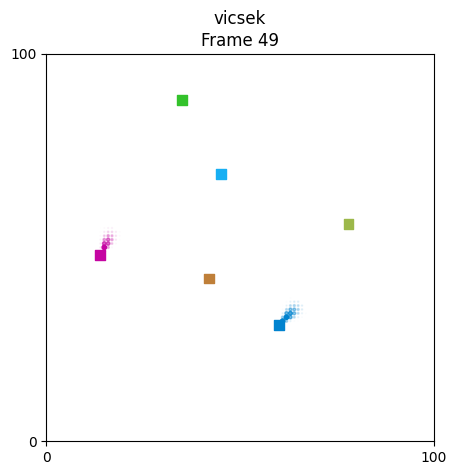

In [25]:
foragersDF = sim_v_object.foragersDF
ani = animate_predictors(
    foragersDF,
    sim_v_object.derived_quantities["vicsek"],
    predictor_name="vicsek",
    forager_position_indices=range(N),
    forager_predictor_indices=[0,4],
    grid_size=sim_v_object.grid_size,
    random_state=10,
    size_multiplier=10,
    fMin=0,
    fMax=50,
    frames_skipped=1,
)
HTML(ani.to_jshtml())

### Inference using raw predictors and scores

--------------------------------------------------
Inference using nextStep_sublinear score
--------------------------------------------------


2024-10-07 17:20:39,926 - Starting SVI inference with 1000 iterations.
2024-10-07 17:20:39,949 - Step 0, elbo loss: 1095720.93613054
2024-10-07 17:20:42,873 - Step 200, elbo loss: -55266.144843281596
2024-10-07 17:20:45,669 - Step 400, elbo loss: -70471.34924131585
2024-10-07 17:20:48,518 - Step 600, elbo loss: -71019.12746985402
2024-10-07 17:20:51,251 - Step 800, elbo loss: -70523.72189129094
2024-10-07 17:20:54,086 - SVI inference completed in 14.16 seconds.


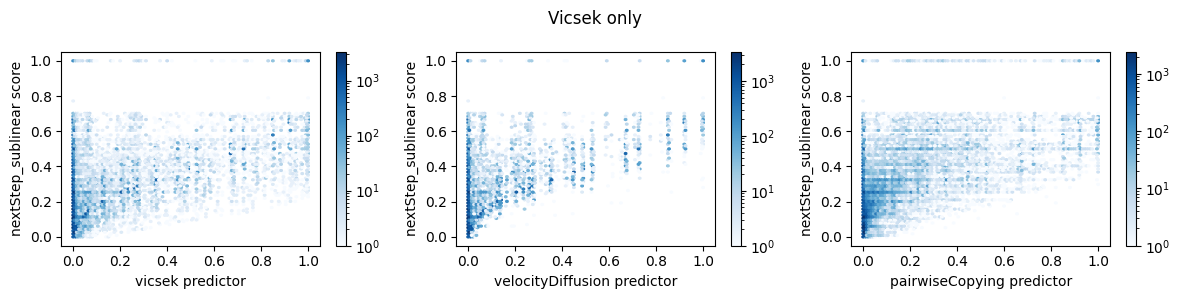

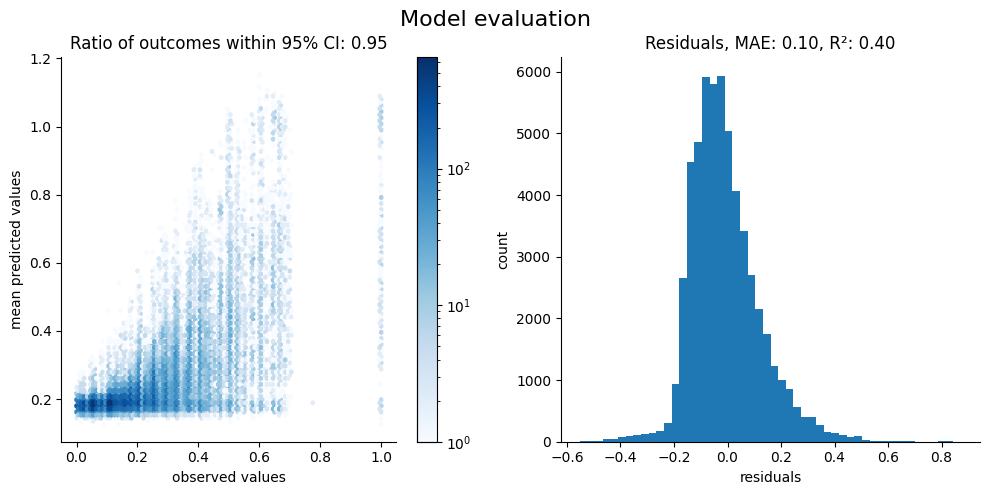

--------------------------------------------------
Inference using nextStepExponential score
--------------------------------------------------


2024-10-07 17:21:07,054 - Starting SVI inference with 1000 iterations.
2024-10-07 17:21:07,083 - Step 0, elbo loss: 9634.231852114146
2024-10-07 17:21:10,615 - Step 200, elbo loss: -42125.43336535999
2024-10-07 17:21:13,992 - Step 400, elbo loss: -67963.99953033155
2024-10-07 17:21:17,959 - Step 600, elbo loss: -80016.82802030921
2024-10-07 17:21:20,820 - Step 800, elbo loss: -80481.1739462845
2024-10-07 17:21:24,384 - SVI inference completed in 17.33 seconds.


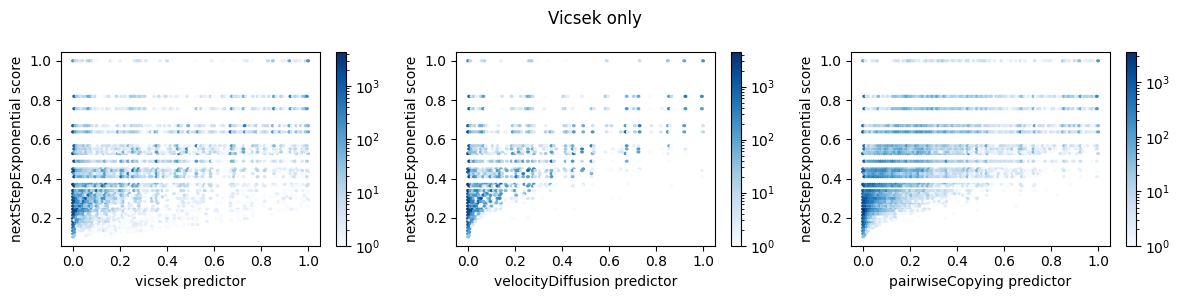

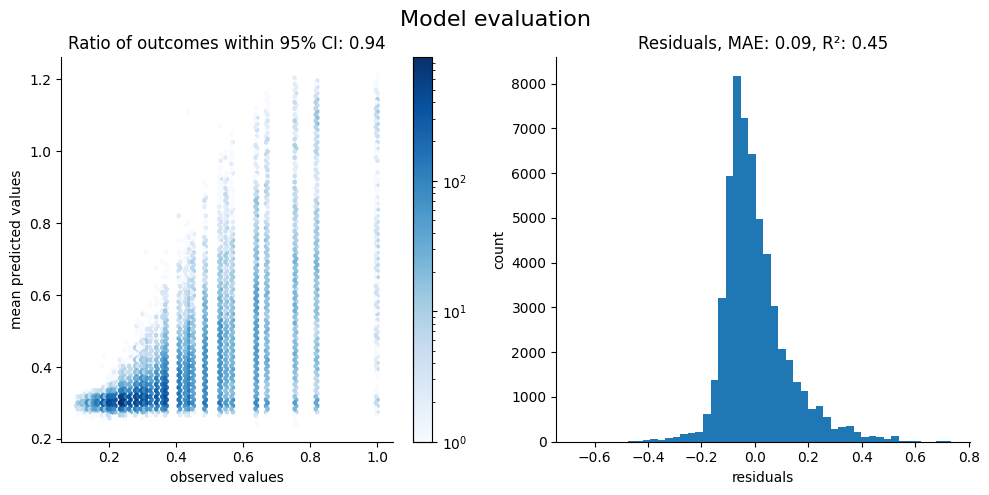

In [26]:
score_names = ["nextStep_sublinear", "nextStepExponential"]
predictor_names = ["vicsek", "velocityDiffusion","pairwiseCopying"]

for score_name in score_names:
    print("-"*50)
    print(f"Inference using {score_name} score")
    print("-"*50)
    predictors, score = get_tensors_for_inference(
        derivedDF, predictor_names=predictor_names, score_names=[score_name]
    )
    plot_density(predictors, score, "Vicsek only")
    
    model = FishModel(predictors, score)
    guide, samples = run_svi_and_get_samples(
        model, predictors, score, verbose=True, num_samples=1000, num_svi_iters=1000
    )
    plot_coefs(samples, f"Vicsek - {score_name}", nbins=100)
    evaluate_performance(
        model, guide, predictors, score, num_samples=100, sampling_fraction=0.5
    )

### Inference using eCDF normalized predictors and scores

--------------------------------------------------
Inference using nextStep_sublinear_scaled score
--------------------------------------------------


2024-10-07 17:21:38,776 - Starting SVI inference with 1000 iterations.
2024-10-07 17:21:38,803 - Step 0, elbo loss: 80531.04859751214
2024-10-07 17:21:42,025 - Step 200, elbo loss: 2554.6530926807804
2024-10-07 17:21:45,079 - Step 400, elbo loss: -1821.82544981145
2024-10-07 17:21:48,164 - Step 600, elbo loss: -4278.440401451407
2024-10-07 17:21:51,493 - Step 800, elbo loss: -3012.3303622003514
2024-10-07 17:21:54,864 - SVI inference completed in 16.09 seconds.


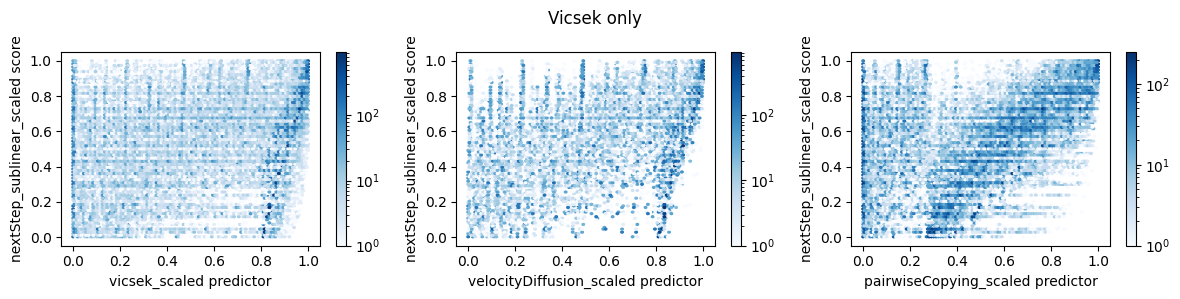

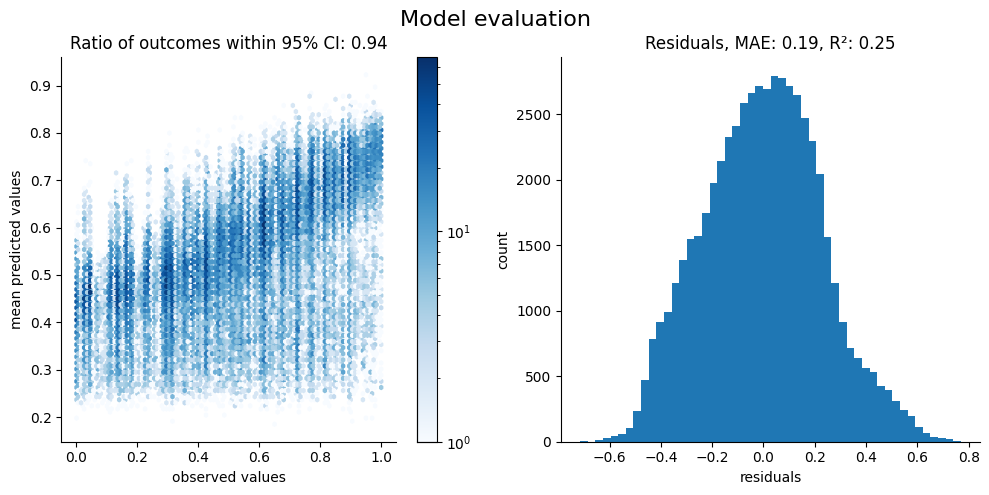

--------------------------------------------------
Inference using nextStepExponential_scaled score
--------------------------------------------------


2024-10-07 17:22:08,707 - Starting SVI inference with 1000 iterations.
2024-10-07 17:22:08,735 - Step 0, elbo loss: 23598.95469711032
2024-10-07 17:22:11,788 - Step 200, elbo loss: -41838.84483517183
2024-10-07 17:22:14,882 - Step 400, elbo loss: -53446.038494134336
2024-10-07 17:22:18,149 - Step 600, elbo loss: -57900.33618767939
2024-10-07 17:22:21,102 - Step 800, elbo loss: -58385.203835456705
2024-10-07 17:22:24,015 - SVI inference completed in 15.31 seconds.


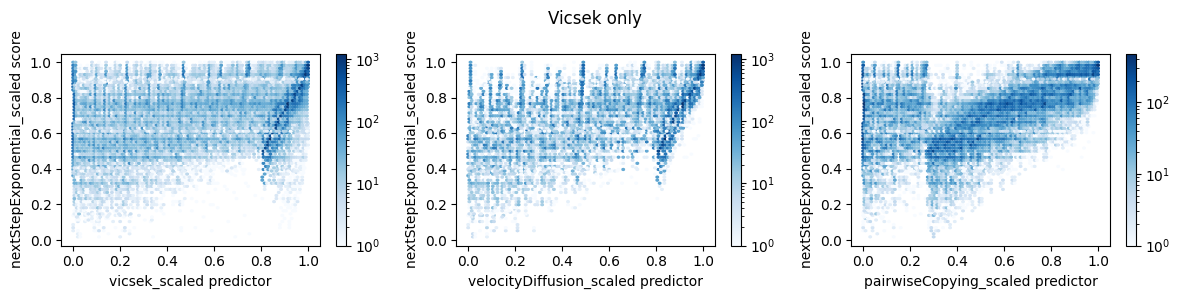

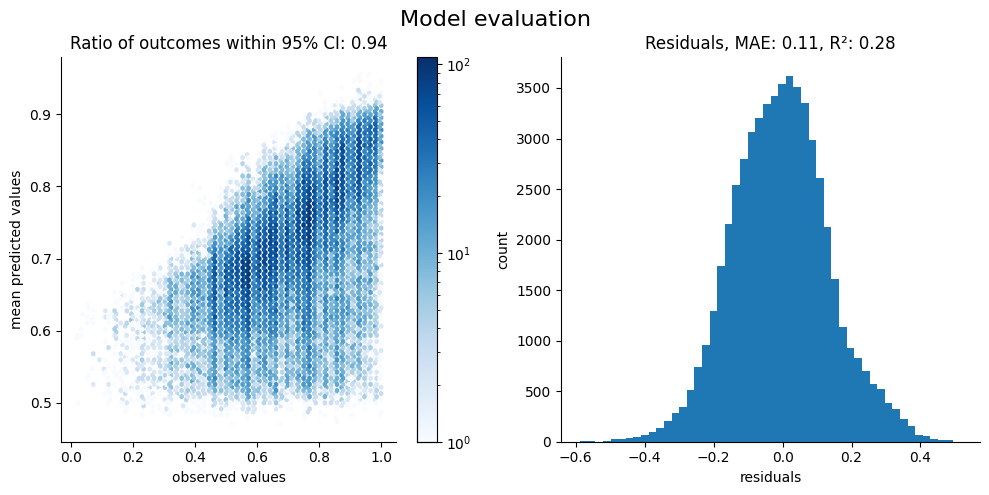

In [27]:
score_names = ["nextStep_sublinear_scaled", "nextStepExponential_scaled"]
predictor_names = ["vicsek_scaled", "velocityDiffusion_scaled","pairwiseCopying_scaled"]

for score_name in score_names:
    print("-"*50)
    print(f"Inference using {score_name} score")
    print("-"*50)
    predictors, score = get_tensors_for_inference(
        derivedDF, predictor_names=predictor_names, score_names=[score_name]
    )
    plot_density(predictors, score, "Vicsek only")
    
    model = FishModel(predictors, score)
    guide, samples = run_svi_and_get_samples(
        model, predictors, score, verbose=True, num_samples=1000, num_svi_iters=1000
    )
    plot_coefs(samples, f"Vicsek - {score_name}", nbins=100)
    evaluate_performance(
        model, guide, predictors, score, num_samples=100, sampling_fraction=0.5
    )